In [1]:
from os.path import join, exists, abspath, dirname
import pandas as pd
import numpy as np
import openpyxl

In [2]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import cm, colors

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [5]:
dir_root = '/mnt/ext5/GP'

In [6]:
list_group = np.array(['baseline', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz'])
list_group = ['No stim',r'DLPFC$_{cTBS}$',r'M1$_{cTBS}$',r'DLPFC$_{20Hz}$']

## Loading the data

In [7]:
fname = '/home/sungbeenpark/github/GloveProject_TMS/results/behav.success_rate.xlsx'
df = pd.read_excel(fname)
df

,subj,group,block,success_rate
0,GA01,No stim,0,0.225833
1,GA01,No stim,1,0.221389
2,GA01,No stim,2,0.370833
3,GA01,No stim,3,0.316389
4,GA01,No stim,4,0.341389
...,...,...,...,...
1915,GP75,DLPFC$_{20Hz}$,19,0.363333
1916,GP75,DLPFC$_{20Hz}$,20,0.253333
1917,GP75,DLPFC$_{20Hz}$,21,0.213611
1918,GP75,DLPFC$_{20Hz}$,22,0.250000


**Hierarchical Structure**

- level 1: subject (GA01 ~ GP75); this is the "$i$" in the equation.
- level 2: group (baseline ~ DLPFC_20Hz); this is the "$j$" in the equation.
- level 3: TMS (no stim vs stim); This level is not modeled in the LMM equation.

---

## Note

StatsModels formula api uses `Patsy` to handle passing the formulas. The pseudo code looks like the following:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + independent_variable2 + independent_variablen", data = df).fit()
```

To tell the model that a variable is categorical, it needs to be wrapped in C(independent_variable). The pseudo code with a categorical independent variable looks like:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + C(independent_variable2)", data = df).fit()
```

By default, `Patsy` chooses the first categorical variable as the reference category; it's possible to change the reference category if desired. In order to do this, one needs to specify the reference category while one is specifying the variable is a categorical variable. Pseduo code is as follows:
```
smf.mixedlm("dependent_variable ~ independent_variable1 + C(independent_variable2, Treatment(categorical_group))", data = df).fit()
```

Where categorical_group is the desired reference group.

[pythonfordatascience](https://www.pythonfordatascience.org/mixed-effects-regression-python/#:~:text=Mixed%20effect%20models%20are%20also%20known%20as)

---

## Comparing

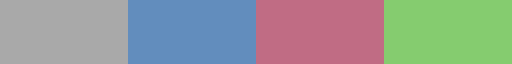

In [8]:
tmp = cm.turbo(np.linspace(0.1,1.0,4))
# palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']

colors.ListedColormap(palette)

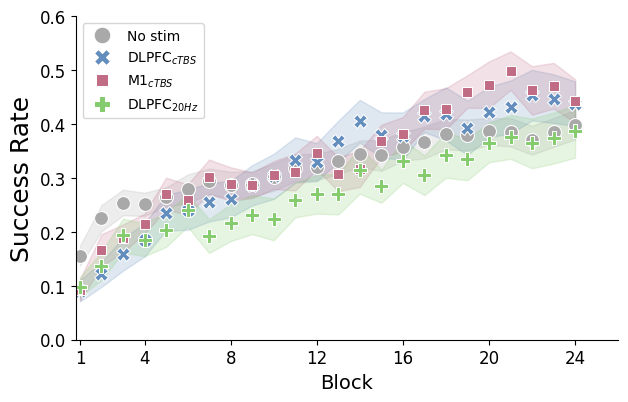

In [9]:
fig, ax = plt.subplots(figsize=(7, 4.2))

g = sns.lineplot(
    data=df,
    x='block', y='success_rate', hue='group',
    hue_order=list_group,
    style='group', dashes=False, markers=True, markersize=10,
    errorbar='se', err_style='band', linestyle='',
    palette=palette,
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
g.legend(markerscale=1.2)

major = [0, 3, 7, 11, 15, 19, 23]
g.set_xlim(-0.2, 25)
g.set_xticks(major)
g.set_xticklabels([x + 1 for x in major])
g.set_xlabel('Block', fontsize=14)
# g.grid(True, linestyle=':', which='major', axis='both')

g.set_ylim(0,.6)
g.set_ylabel('Success Rate', fontsize=18)

g.tick_params(axis="both", labelsize=12, which='major')

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

# # ax.set_xticklabels([1,5,9,13,17,21,24])

In [10]:
group_ref = 'No stim'
model = smf.mixedlm(
    "success_rate ~ block + C(group, Treatment('%s')) + block:C(group, Treatment('%s'))"%(group_ref,group_ref),
    df, groups=df['subj']
)
result = model.fit()
print(result.summary())

                              Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              success_rate
No. Observations:              1920                 Method:                          REML        
No. Groups:                    80                   Scale:                           0.0092      
Min. group size:               24                   Log-Likelihood:                  1604.4279   
Max. group size:               24                   Converged:                       Yes         
Mean group size:               24.0                                                              
-------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                         

In [11]:
# result.t_test_pairwise(
#     term_name ="C(group, Treatment('%s'))"%(group_ref),
#     alpha=0.05, method='bonferroni',
#     # factor_labels=['A','B','C','D']
# )

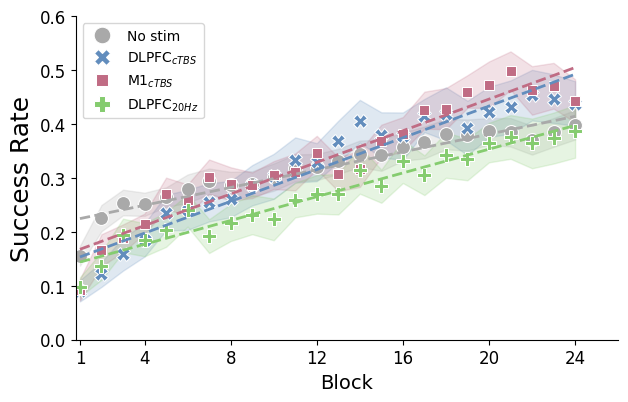

In [12]:
## no stim
group = list_group[0]
slope = result.params.block
intercept = result.params.Intercept
x = np.array([ii for ii in range(24)])
y = x * slope + intercept
ax.plot(
    x,y,
    label=''%result.params.block,
    linestyle='--', linewidth=2, alpha=1,
    color=palette[0] # No-stim
)
## others
for ii, group in enumerate(list_group[1:]):
    key = "C(group, Treatment('No stim'))[T.%s]"%group
    slope = result.params.block+result.params['block:%s'%key]
    intercept = result.params.Intercept+result.params[key]
    y = x * slope + intercept
    ax.plot(
        x,y,
        label=''%result.params.block,
        linestyle='--', linewidth=2, alpha=1,
        color=palette[ii+1]
    )
    ## statistics
    # x1 = 23.25
    # y1 = x1 * slope + intercept
    # color = palette[np.where(np.array(list_group)==group)[0][0]]
    
    # pval = result.pvalues['block:%s'%key] * 3
    # coef = result.params['block:%s'%key]
    # print(group, pval, coef)
    # ax.text(
    #     x1, y1,
    #     convert_pvalue_to_asterisks(pval),
    #     fontsize=16, color=color,
    #     ha='left', va='center', rotation=0
    # )

## statistics
# x1, x2 = 6, 7
# y1, y2 = 0.48, 0.565
# ax.plot([x1,x2],[y1,y1],linestyle='-',color=color)
# ax.plot([x1,x2],[y2,y2],linestyle='-',color=color)
# ax.plot([x2,x2],[y1,y2],linestyle='-',color=color)
# ax.text(
#     x2+0.25, (y1+y2)*0.5,
#     convert_pvalue_to_asterisks(pval),
#     fontsize=16, color=color,
#     ha='left', va='center', rotation=90
# )

fig

In [13]:
lines = {'group':[], 'slope':[], 'sem':[], 'tval':[], 'pval':[]}
slope_ref = 0
for ii, group in enumerate(list_group):
    if ii==0:
        key = ''
    else:
        key = ":C(group, Treatment('No stim'))[T.%s]"%group
    slope = result.params.block+result.params['block%s'%key] + slope_ref
    if ii==0:
        slope_ref = slope
    sem = result.bse_fe['block%s'%key]
    tval = result.tvalues['block%s'%key] # It is effectively a z-statistics
    pval = result.pvalues['block%s'%key] * 3
    lines['group'].append(group)
    lines['slope'].append(slope)
    lines['sem'].append(sem)
    lines['tval'].append(tval)
    lines['pval'].append(pval)

dg = pd.DataFrame(lines)
dg = dg.set_index('group', drop=True).rename_axis(None)
dg

,slope,sem,tval,pval
No stim,0.016499,0.000517,15.965437,6.674309e-57
DLPFC$_{cTBS}$,0.031237,0.000859,7.552679,1.279181e-13
M1$_{cTBS}$,0.031161,0.000859,7.463375,2.530018e-13
DLPFC$_{20Hz}$,0.027525,0.000876,3.169528,4.580599e-03


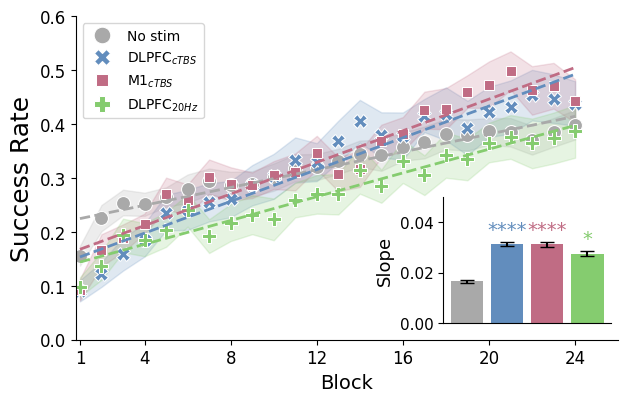

In [14]:
# 작은 axes 추가 (우측 하단)
inset_ax = fig.add_axes([0.65, 0.15, 0.24, 0.3])  # (left, bottom, width, height)
inset_ax.bar(np.arange(len(dg)), dg['slope'], yerr=dg['sem'], capsize=5, color=palette)

inset_ax.set_xticks([])
inset_ax.set_ylim(0,0.05)
inset_ax.set_ylabel('Slope', fontsize=13)

inset_ax.spines['right'].set_visible(False)
inset_ax.spines['top'].set_visible(False)

inset_ax.tick_params(axis="both", labelsize=11, which='major')
for ii, group in enumerate(list_group[1:]):
    pval = dg.loc[group,'pval'] * 3 # Bonferroni Correction
    x = ii+1
    y = dg.loc[group,'slope'] + dg.loc[group,'sem']
    inset_ax.text(
        x, y+0.005,
        convert_pvalue_to_asterisks(pval),
        fontsize=14, color=palette[x],
        ha='center', va='center', rotation=0
    )

fig

In [14]:
fig.savefig(
    join('/mnt/f/fig.2a.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---

#### Curve Fitting (individual)

In [10]:
from scipy import optimize
import random
from random import random as rand

In [11]:
def func_exp(x, a, b, c):
    return a * (1 - np.exp(-b * x)) + c

In [12]:
def func_linear(x, a, b):
    return b * x + a

In [13]:
xdata=range(24)
# df_opt = pd.DataFrame(columns=['subj','group','a','b','c'])
df_opt = pd.DataFrame(columns=['subj','group','a','b'])
# list_subj = random.choices(df.subj.unique(), k=len(df.subj.unique()))
list_subj = df.subj.unique()
for subj in list_subj:
    group = df[df.subj==subj].group.values[0]
    ydata=df[df.subj==subj].success_rate

    iter_ = range(int(1e2))
    # popt_, res = [0,0,0], 100
    popt_, res = [0,0], 100
    for i in iter_:
        popt_, pcov_, info_, _, _ = optimize.curve_fit(
            # func_exp,
            func_linear,
            xdata, ydata,
            maxfev=300,
            # p0=[0.5*rand(),rand(),0.5*rand()],
            p0=[rand(),rand()],
            # bounds=([0,0,0], [1.-popt_[-1],5.,0.5]),
            bounds=([0,0], [1,1]),
            full_output=True
        )
        fvec_ = info_['fvec']
        res_ = np.sum(fvec_*fvec_)
        # if (popt_[0]+popt_[2]>=1):
        #     continue
        if (res_<res):
            popt=popt_
            pcov=pcov_
            info=info_
            res=res_
    new_row = pd.Series(
                {
                    'subj':subj, 'group':group,
                    # 'a':popt[0], 'b':popt[1], 'c':popt[2],
                    'a':popt[0], 'b':popt[1],
                    'res':res
                    # 'cov':pcov
                }
            )
    df_opt = pd.concat(
        [df_opt, new_row.to_frame().T]
        , axis='index'
        , ignore_index=True
    )
df_opt
# plt.scatter(xdata, ydata)
# plt.plot(xdata, func_exp(xdata, *popt))
# plt.ylim(0,0.8)

,subj,group,a,b,res
0,GA01,No stim,0.301163,0.005724,0.075925
1,GA02,No stim,0.333245,0.009883,0.159823
2,GA05,No stim,0.108105,0.025157,0.229873
3,GA07,No stim,0.222269,0.004994,0.202864
4,GA08,No stim,0.397684,0.00386,0.226004
...,...,...,...,...,...
75,GP71,DLPFC$_{20Hz}$,0.088881,0.003683,0.053452
76,GP72,DLPFC$_{20Hz}$,0.417771,0.008281,0.157318
77,GP73,DLPFC$_{20Hz}$,0.148486,0.006086,0.121288
78,GP74,DLPFC$_{20Hz}$,0.204606,0.0,0.184529


---

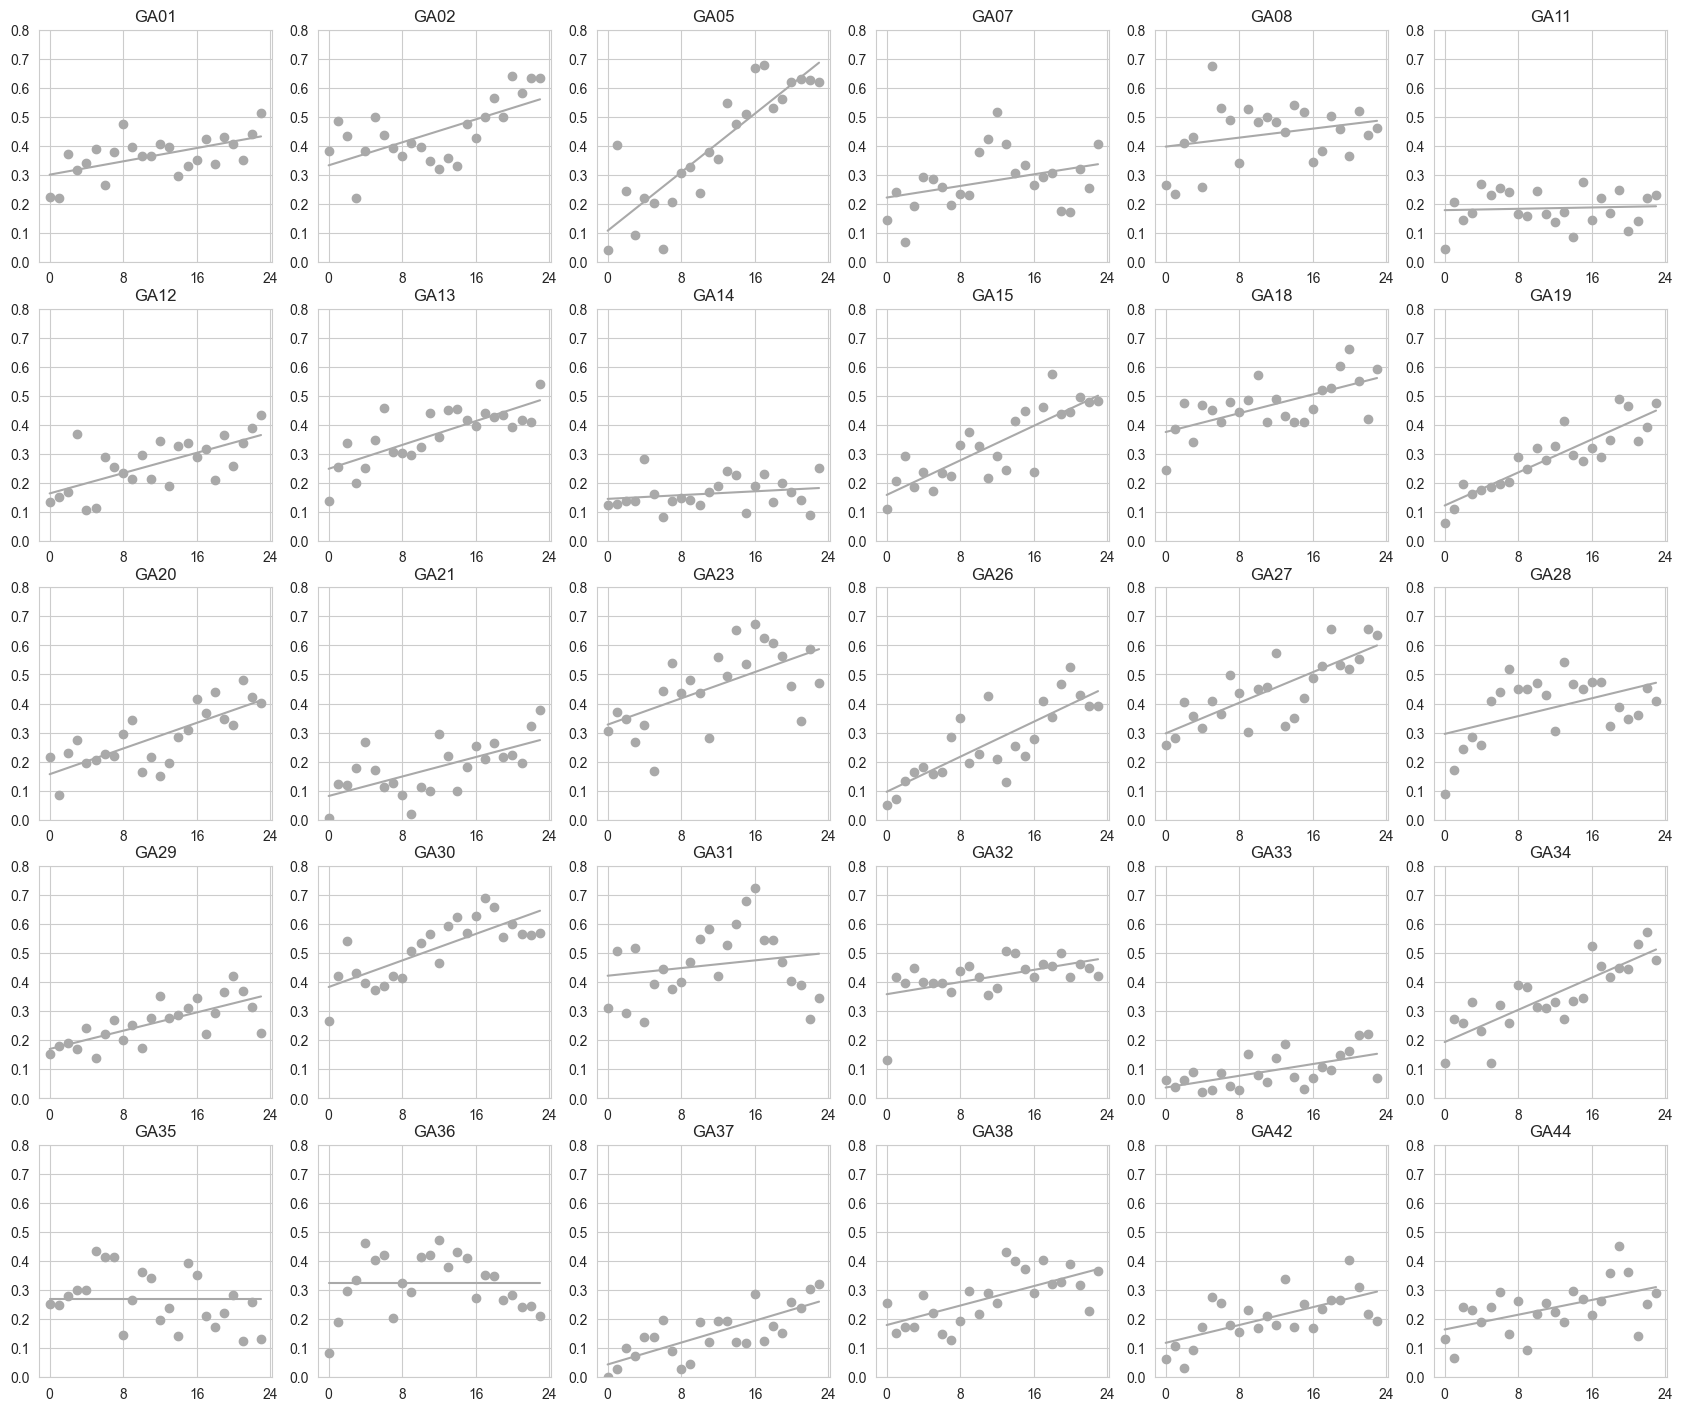

In [14]:
nrows = 5
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols,3.5*nrows))
axs = np.concatenate(axs)

group = 'No stim'
for ii, subj in enumerate(df[df.group==group].subj.unique()):
    ax = axs[ii]
    color = palette[0]
    ax.scatter(xdata, df[df.subj==subj].success_rate, color=color)
    tmp = df_opt[df_opt.subj==subj]
    ax.plot(xdata,func_linear(xdata, tmp.a.values[0], tmp.b.values[0]), color=color)
    ax.set_title(subj)
    ax.set_xticks([0,8,16,24])
    ax.set_ylim(0, 0.8)

(0.0, 0.6)

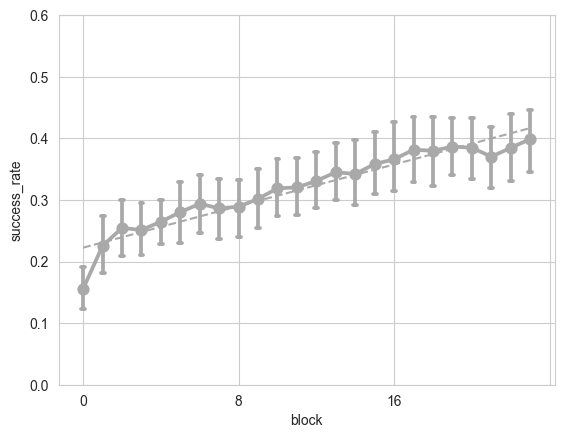

In [15]:
g = sns.pointplot(
    data=df[df.group==group],
    x='block', y='success_rate',
    capsize=0.2,
    color=color
)
df_tmp = df_opt[df_opt.group==group]
g.plot(xdata, func_linear(xdata, df_tmp.a.mean(), df_tmp.b.mean()), color=color, linestyle='--')
g.set_xticks([0,8,16,24])
g.grid(axis='x')
g.set_ylim(0,0.6)

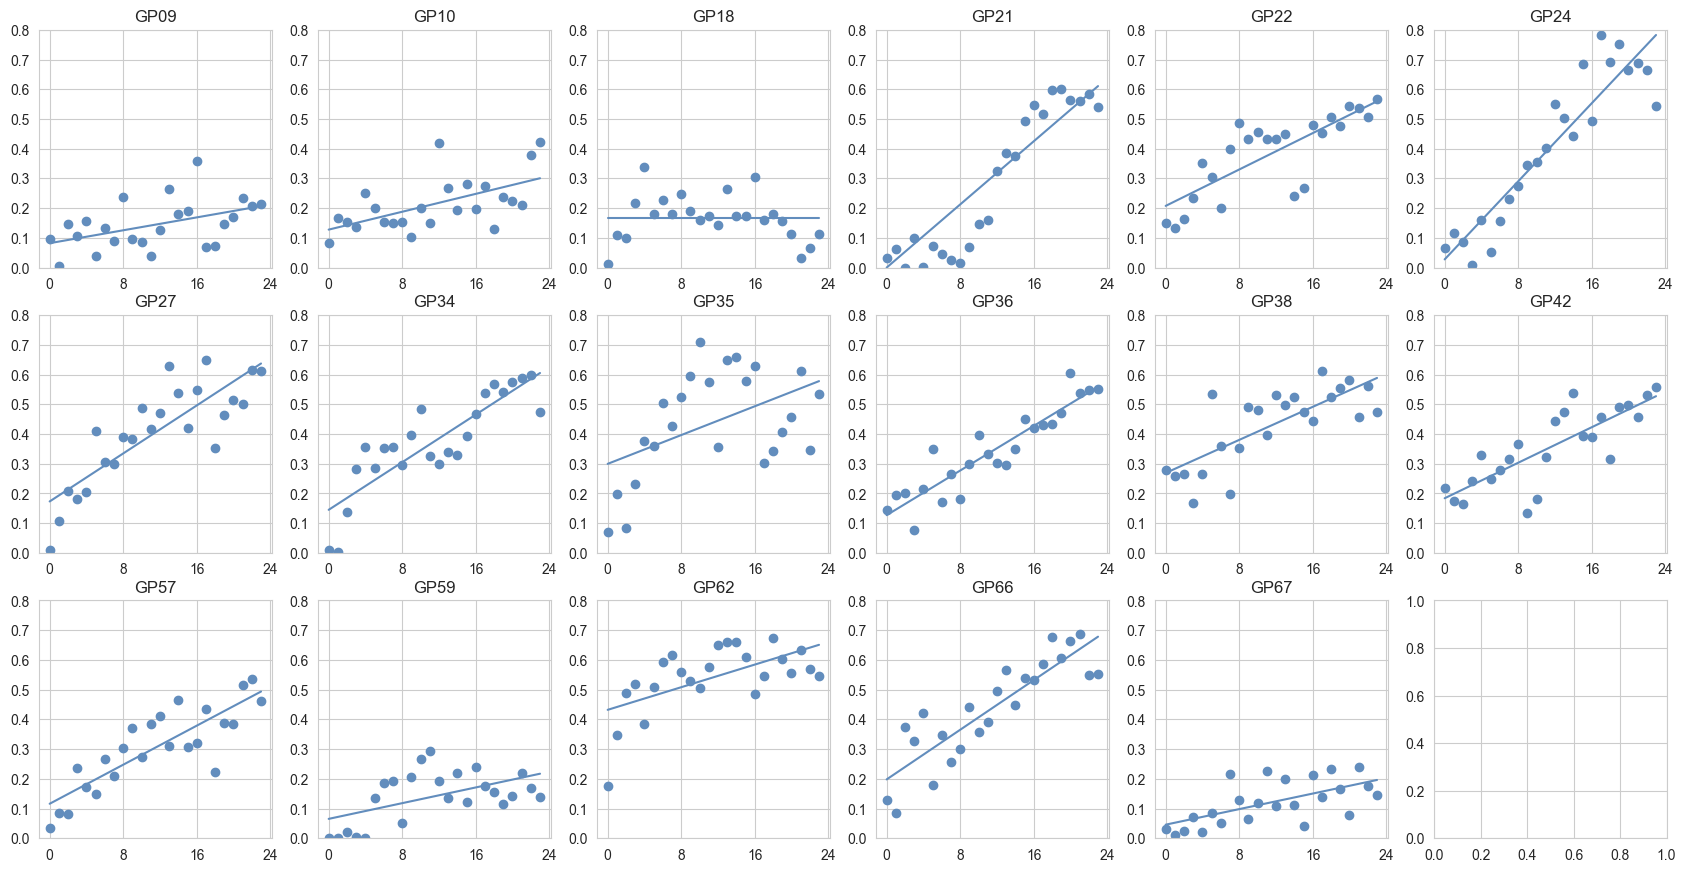

In [16]:
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols,3.5*nrows))
axs = np.concatenate(axs)

group = 'DLPFC$_{cTBS}$'
for ii, subj in enumerate(df[df.group==group].subj.unique()):
    ax = axs[ii]
    color = palette[1]
    ax.scatter(xdata, df[df.subj==subj].success_rate, color=color)
    tmp = df_opt[df_opt.subj==subj]
    ax.plot(xdata,func_linear(xdata, tmp.a.values[0], tmp.b.values[0]), color=color)
    ax.set_title(subj)
    ax.set_xticks([0,8,16,24])
    ax.set_ylim(0, 0.8)

(0.0, 0.6)

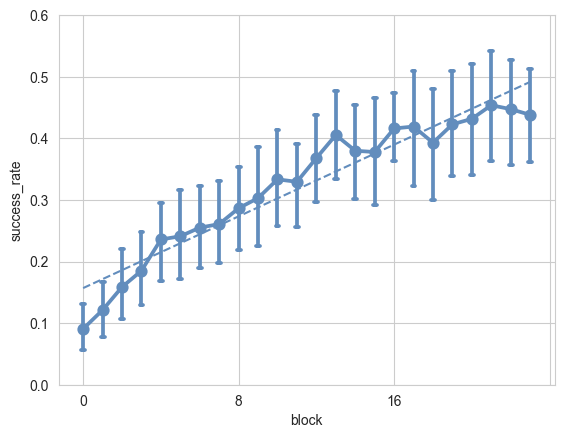

In [17]:
g = sns.pointplot(
    data=df[df.group==group],
    x='block', y='success_rate',
    capsize=0.2,
    color=color
)
df_tmp = df_opt[df_opt.group==group]
g.plot(xdata, func_linear(xdata, df_tmp.a.mean(), df_tmp.b.mean()), color=color, linestyle='--')
g.set_xticks([0,8,16,24])
g.grid(axis='x')
g.set_ylim(0,0.6)

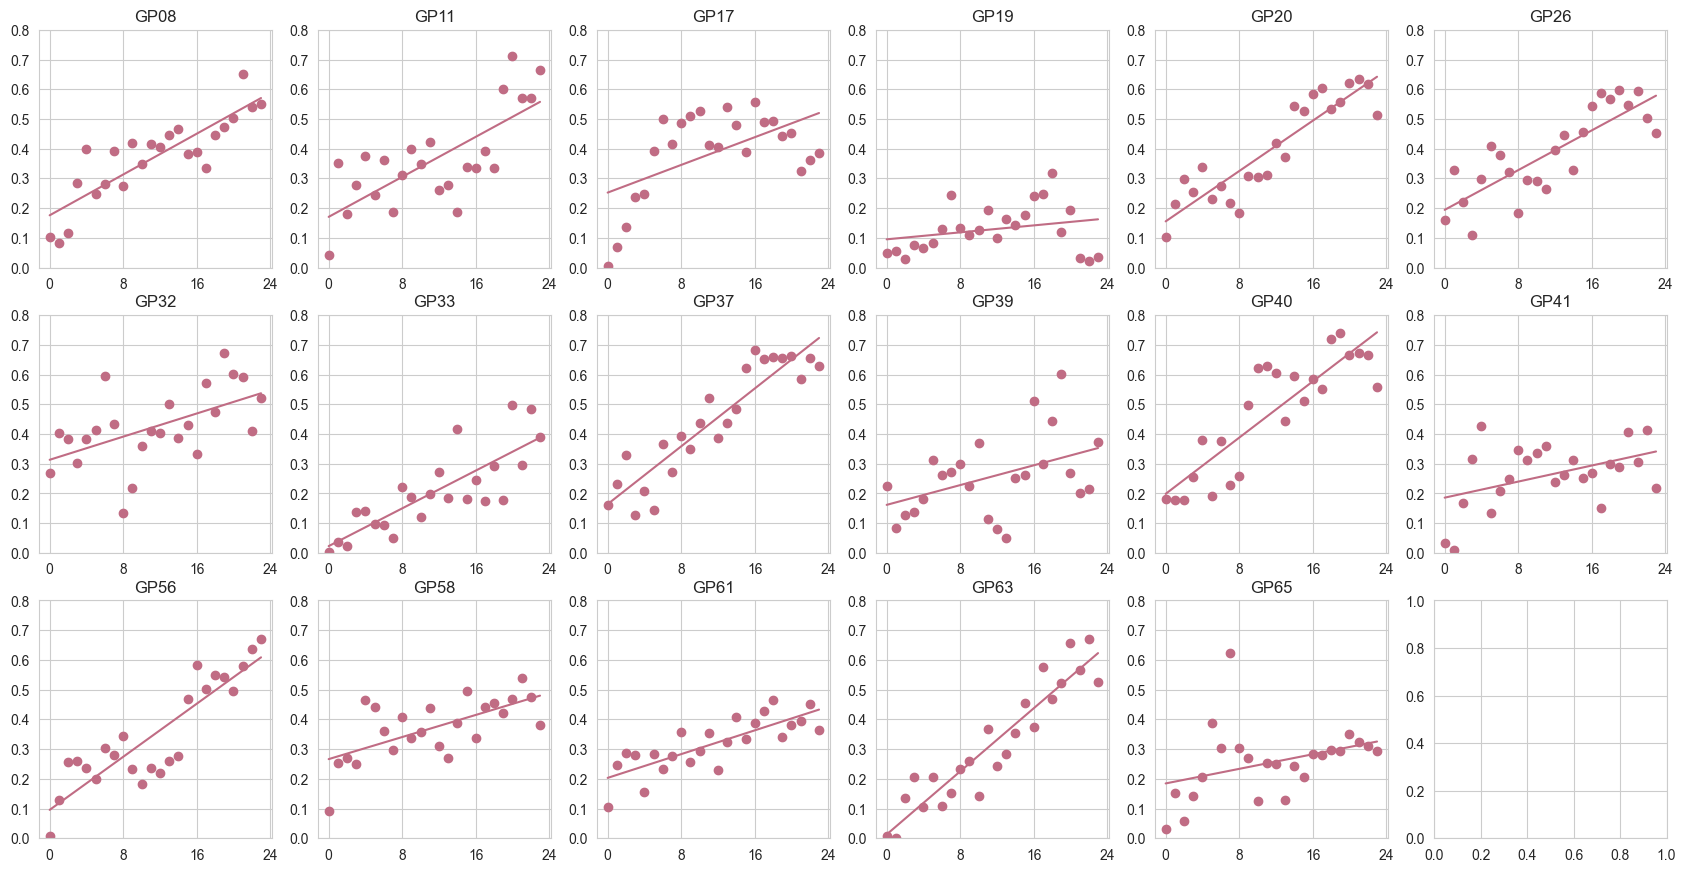

In [18]:
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols,3.5*nrows))
axs = np.concatenate(axs)

group = 'M1$_{cTBS}$'
for ii, subj in enumerate(df[df.group==group].subj.unique()):
    ax = axs[ii]
    color = palette[2]
    ax.scatter(xdata, df[df.subj==subj].success_rate, color=color)
    tmp = df_opt[df_opt.subj==subj]
    ax.plot(xdata,func_linear(xdata, tmp.a.values[0], tmp.b.values[0]), color=color)
    ax.set_title(subj)
    ax.set_xticks([0,8,16,24])
    ax.set_ylim(0, 0.8)

(0.0, 0.6)

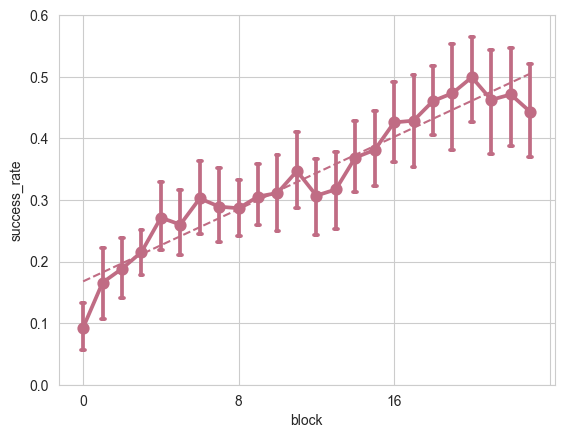

In [19]:
g = sns.pointplot(
    data=df[df.group==group],
    x='block', y='success_rate',
    capsize=0.2,
    color=color
)
df_tmp = df_opt[df_opt.group==group]
g.plot(xdata, func_linear(xdata, df_tmp.a.mean(), df_tmp.b.mean()), color=color, linestyle='--')
g.set_xticks([0,8,16,24])
g.grid(axis='x')
g.set_ylim(0,0.6)

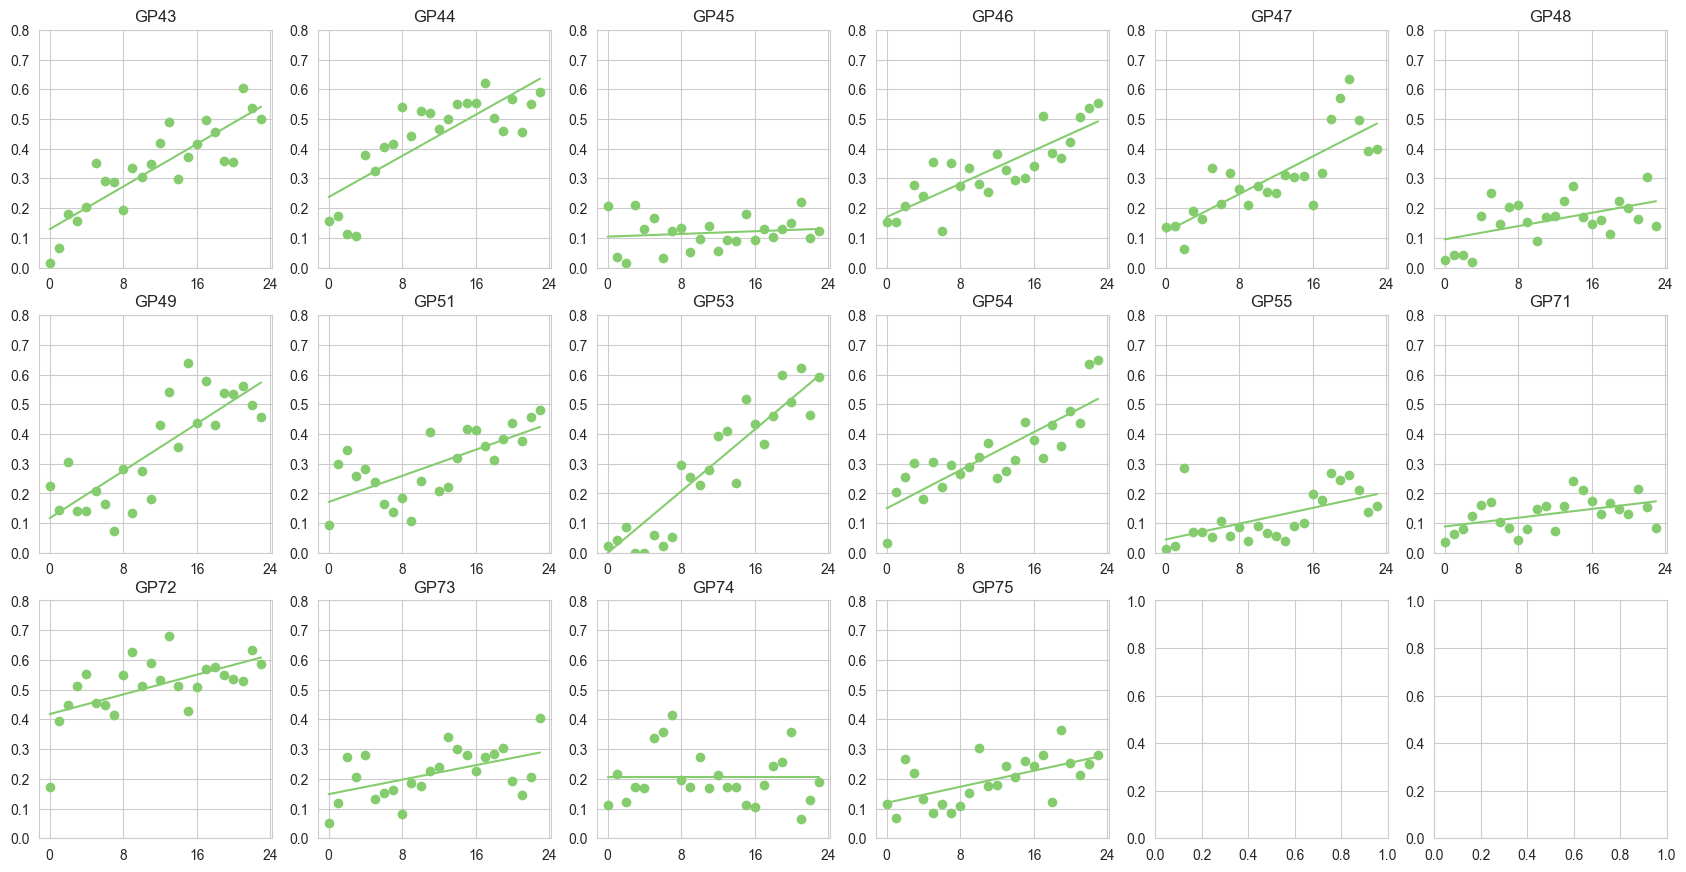

In [20]:
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols,3.5*nrows))
axs = np.concatenate(axs)

group = 'DLPFC$_{20Hz}$'
for ii, subj in enumerate(df[df.group==group].subj.unique()):
    ax = axs[ii]
    color = palette[3]
    ax.scatter(xdata, df[df.subj==subj].success_rate, color=color)
    tmp = df_opt[df_opt.subj==subj]
    ax.plot(xdata,func_linear(xdata, tmp.a.values[0], tmp.b.values[0]), color=color)
    ax.set_title(subj)
    ax.set_xticks([0,8,16,24])
    ax.set_ylim(0, 0.8)

(0.0, 0.6)

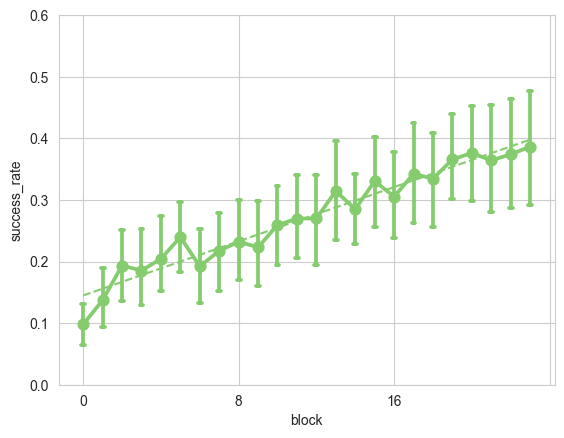

In [21]:
g = sns.pointplot(
    data=df[df.group==group],
    x='block', y='success_rate',
    capsize=0.2,
    color=color
)
df_tmp = df_opt[df_opt.group==group]
g.plot(xdata, func_linear(xdata, df_tmp.a.mean(), df_tmp.b.mean()), color=color, linestyle='--')
g.set_xticks([0,8,16,24])
g.grid(axis='x')
g.set_ylim(0,0.6)

---

one-way ANOVA

In [22]:
import pingouin as pg

pg.anova(
    data=df_opt[df_opt.group != 'No stim'].astype({'b':float}),
    dv='b', between='group',
    detailed=False, effsize="np2"
)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,47,1.213909,0.306176,0.049118


,subj,group,param,value
0,GA01,No stim,a,0.301163
1,GA02,No stim,a,0.333245
2,GA05,No stim,a,0.108105
3,GA07,No stim,a,0.222269
4,GA08,No stim,a,0.397684
...,...,...,...,...
155,GP71,DLPFC$_{20Hz}$,b,0.003683
156,GP72,DLPFC$_{20Hz}$,b,0.008281
157,GP73,DLPFC$_{20Hz}$,b,0.006086
158,GP74,DLPFC$_{20Hz}$,b,0.0


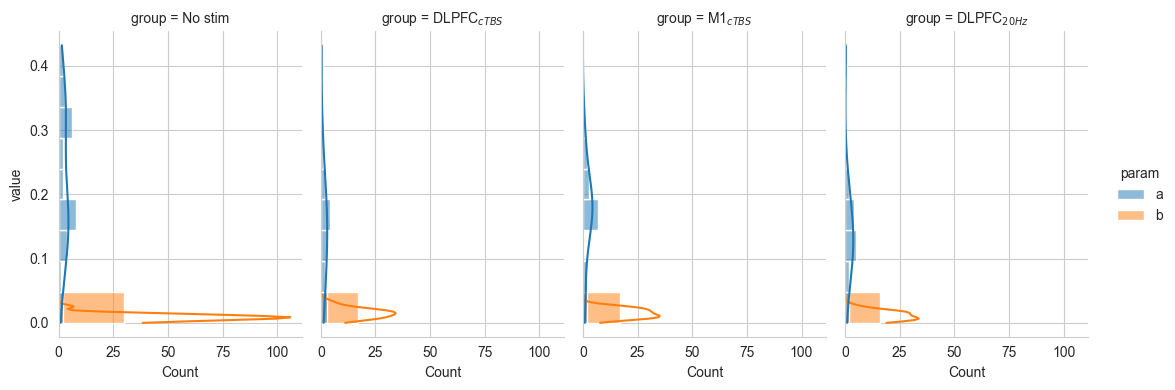

In [23]:
# df_opt_long = df_opt.melt(id_vars=['subj','group'], value_vars=['a','b','c'], var_name='param', value_name='value')
df_opt_long = df_opt.melt(id_vars=['subj','group'], value_vars=['a','b'], var_name='param', value_name='value')
g = sns.displot(
    data=df_opt_long, col='group',
    y='value',
    hue='param',
    kind='hist', kde=True,
    height=4, aspect=.7
)
df_opt_long
# g.axvline(popt[0], ls='--', color='b')

Post-hoc

In [24]:
from scipy import optimize, stats

print('comparison (intercept)')
a = df_opt[df_opt.group=='No stim'].a.astype(float)
for group in list_group[1:]:
    print('No stim vs. %s'%group)
    b = df_opt[df_opt.group==group].a.astype(float)
    res = stats.ttest_ind(a,b)
    tval, pval = res
    pval_c = pval * 3
    dof = res.df
    print(
        'T(%d) = %.3f / uncorrected %sp=%.5f (corrected %sp=%.5f)\n'
        %(dof, tval, convert_pvalue_to_asterisks(pval),pval, convert_pvalue_to_asterisks(pval_c),pval_c)
    )

comparison (intercept)
No stim vs. DLPFC$_{cTBS}$
T(45) = 1.971 / uncorrected nsp=0.05488 (corrected nsp=0.16463)

No stim vs. M1$_{cTBS}$
T(45) = 1.797 / uncorrected nsp=0.07908 (corrected nsp=0.23724)

No stim vs. DLPFC$_{20Hz}$
T(44) = 2.389 / uncorrected *p=0.02125 (corrected nsp=0.06375)



In [97]:
from scipy import optimize, stats

print('comparison (slope)')
a = df_opt[df_opt.group=='No stim'].b.astype(float)
for group in list_group[1:]:
    print('No stim vs. %s'%group)
    b = df_opt[df_opt.group==group].b.astype(float)
    res = stats.ttest_ind(a,b)
    tval, pval = res
    pval_c = pval * 3
    dof = res.df
    print(
        'T(%d) = %.3f / uncorrected %sp=%.5f (corrected %sp=%.5f)\n'
        %(dof, tval, convert_pvalue_to_asterisks(pval),pval, convert_pvalue_to_asterisks(pval_c),pval_c)
    )

comparison (slope)
No stim vs. DLPFC$_{cTBS}$
T(45) = -3.077 / uncorrected **p=0.00355 (corrected *p=0.01066)

No stim vs. M1$_{cTBS}$
T(45) = -3.382 / uncorrected **p=0.00150 (corrected **p=0.00449)

No stim vs. DLPFC$_{20Hz}$
T(44) = -1.353 / uncorrected nsp=0.18287 (corrected nsp=0.54860)



---

### Random Intercept Model

1. $Success\ Rate \sim time + (1|subject)$ or $Success\ Rate \sim time + 1$ or $Success\ Rate \sim time$ ; These are the same notation

$1$ means a random intercept
- fixed effect : **time**
- randome effect : **subject** (*no-stim* group)

**Intercept** : This represents the baseline value of the dependent variable (=$Success\ Rate$) when all other predictors are zero (when *time*=0 and *group=baseline*; the reference group). It is the starting point of the model.

**time** : This represents the effect of *time* on $Success\ Rate$. It shows how $Success\ Rate$ changes over *time*.

2. $Success\ Rate \sim block * group + (1|sujbect)$ or $Success\ Rate \sim block + C(group, Treatment(reference)) + block:C(group, Treatment(reference))$
- fixed effect : **block**, **group** (possibly correlated)
- random effect : **subject**

i) Reference group = No-stim

In [73]:
group_ref = 'No stim'

Reference Group = No stim

## comparison (LME vs. fit) ##
No stim
Slope: 0.00825 vs. 0.00844
intercept: 0.22472 vs. 0.22256

DLPFC$_{cTBS}$
Slope: 0.01474 vs. 0.01455
intercept: 0.15355 vs. 0.15690

M1$_{cTBS}$
Slope: 0.01466 vs. 0.01466
intercept: 0.16778 vs. 0.16778

DLPFC$_{20Hz}$
Slope: 0.01103 vs. 0.01100
intercept: 0.14404 vs. 0.14491

                              Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              success_rate
No. Observations:              1920                 Method:                          REML        
No. Groups:                    80                   Scale:                           0.0092      
Min. group size:               24                   Log-Likelihood:                  1604.4279   
Max. group size:               24                   Converged:                       Yes         
Mean group size:               24.0                                                              


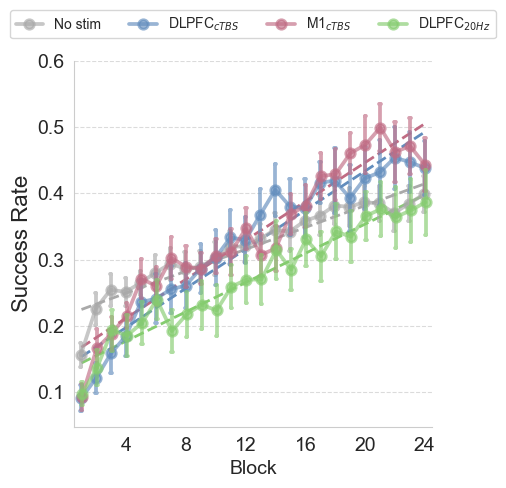

In [95]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

x = np.array([ii for ii in range(24)])
print('Reference Group = %s\n'%group_ref)
model = smf.mixedlm(
    "success_rate ~ block + C(group, Treatment('%s')) + block:C(group, Treatment('%s'))"%(group_ref,group_ref),
    df,
    groups=df['subj']
)
result = model.fit()

## plotting figure
print('## comparison (LME vs. fit) ##')
### no stim
group = 'No stim'
print(group)
slope = result.params.block
intercept = result.params.Intercept
y = x * slope + intercept
ax.plot(
    x,y,
    label=''%result.params.block,
    linestyle='--', linewidth=2,
    color=palette[0] # No-stim
)
df_tmp = df_opt[df_opt.group=='No stim']
print('Slope: %.5f vs. %.5f'%(slope, df_tmp.b.mean()))
print('intercept: %.5f vs. %.5f\n'%(intercept, df_tmp.a.mean()))
### stim
for ii, group in enumerate(list_group[1:]):
    print(group)
    slope = result.params.block+result.params["block:C(group, Treatment('No stim'))[T.%s]"%group]
    intercept = result.params.Intercept+result.params["C(group, Treatment('No stim'))[T.%s]"%group]
    y = x * slope + intercept
    ax.plot(
        x,y,
        label=''%result.params.block,
        linestyle='--', linewidth=2,
        color=palette[ii+1]
    )
    df_tmp = df_opt[df_opt.group==group]
    print('Slope: %.5f vs. %.5f'%(slope, df_tmp.b.mean()))
    print('intercept: %.5f vs. %.5f\n'%(intercept, df_tmp.a.mean()))

pval = result.pvalues.block
# ax.set_title('Ref: %s'%(group_ref))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

g = sns.pointplot(
    data=df,
    x='block', y='success_rate', hue='group', hue_order=list_group,
    errorbar='se', capsize=0.1,
    dodge=True,
    palette=palette, alpha=0.65,
    ax=ax
)
# g.legend().remove()
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.1), ncols=4)
xticks = np.arange(0,24,4)+4
g.set_xticks(xticks-1)
g.set_xticklabels(xticks, fontsize=14)
g.set_xlabel('Block', fontsize=14)

g.set_yticks(np.arange(0.1,0.7,0.1))
g.set_yticklabels(['0.%d'%(ii+1) for ii in range(6)], fontsize=14)
g.set_ylabel('Success Rate', fontsize=16)

print(result.summary())

fig.tight_layout()

**C(group, Treatment('baseline'))[T.DLPFC_cTBS]** : This indicates the effect of the *DLPFC$_{cTBS}$* group compared to the *reference group*. It shows how being in the *baseline* group changes $Success\ Rate$.

**block:C(group, Treatment('baseline'))[T.DLPFC_cTBS]** : This interaction term shows how the effect of *block* on $Success\ Rate$ differs between the *DLPFC$_{cTBS}$* group and the reference group (=*baseline*). It indicates whether the *time* effect is different for the *baseline* group.

ii) Reference group = DLPFC$_{20Hz}$

In [12]:
group_ref = 'DLPFC$_{20Hz}$'

Reference Group = DLPFC$_{20Hz}$

                                 Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                success_rate
No. Observations:                 1920                   Method:                            REML        
No. Groups:                       80                     Scale:                             0.0092      
Min. group size:                  24                     Log-Likelihood:                    1604.4279   
Max. group size:                  24                     Converged:                         Yes         
Mean group size:                  24.0                                                                  
--------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------

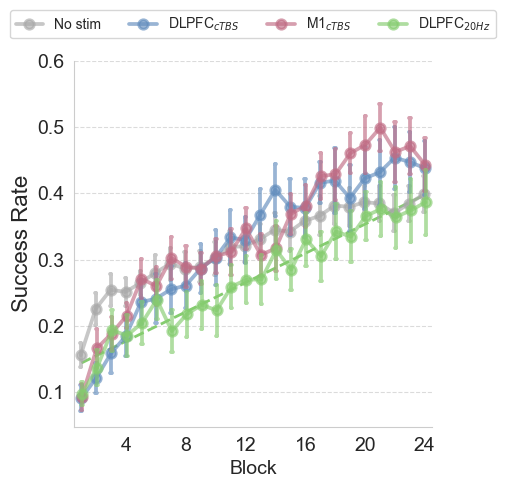

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

x = np.array([ii for ii in range(24)])
print('Reference Group = %s\n'%group_ref)
model = smf.mixedlm(
    "success_rate ~ block + C(group, Treatment('%s')) + block:C(group, Treatment('%s'))"%(group_ref,group_ref),
    df,
    groups=df['subj']
)
result = model.fit()

## plotting figure
y = x * result.params.block + result.params.Intercept
ax.plot(
    x,y,
    label=''%result.params.block,
    linestyle='--', linewidth=2,
    color=palette[-1] # No-stim
)

pval = result.pvalues.block
# ax.set_title('Ref: %s'%(group_ref))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

g = sns.pointplot(
    data=df,
    x='block', y='success_rate', hue='group', hue_order=list_group,
    errorbar='se', capsize=0.1,
    dodge=True,
    palette=palette, alpha=0.65,
    ax=ax
)
# g.legend().remove()
ax.legend(loc='center', bbox_to_anchor=(0.5, 1.1), ncols=4)
xticks = np.arange(0,24,4)+4
g.set_xticks(xticks-1)
g.set_xticklabels(xticks, fontsize=14)
g.set_xlabel('Block', fontsize=14)

g.set_yticks(np.arange(0.1,0.7,0.1))
g.set_yticklabels(['0.%d'%(ii+1) for ii in range(6)], fontsize=14)
g.set_ylabel('Success Rate', fontsize=16)

print(result.summary())

fig.tight_layout()

---